In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sys # Ignore warnings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/My Drive/SYSC5108 Deep Learning Project/Training Set/'
test_dir = '/content/drive/My Drive/SYSC5108 Deep Learning Project/Test Set/'
folders = os.listdir(train_dir)
print(folders)

['Rain', 'Shine', 'Cloudy', 'Sunrise']


In [4]:
# Import necessary libraries and modules
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image

##Loading the dataset and preprocessing



In [5]:
# Set the batch size and image size
batch_size = 32
img_size = 256
num_classes = 4

np.random.seed(42)
tf.random.set_seed(42)

# Create an ImageDataGenerator for the training and validation sets
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.25,  # set the validation split to 25%
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Create separate generators for the training and validation sets
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # set the subset to 'training' for the training set
    shuffle=True,  # shuffle the training set
    seed = 42
)

val_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # set the subset to 'validation' for the validation set
    shuffle=True ,
    seed = 42
)

# Create an ImageDataGenerator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle= False,
    seed = 42 
)

Found 676 images belonging to 4 classes.
Found 224 images belonging to 4 classes.
Found 225 images belonging to 4 classes.


## Visualization

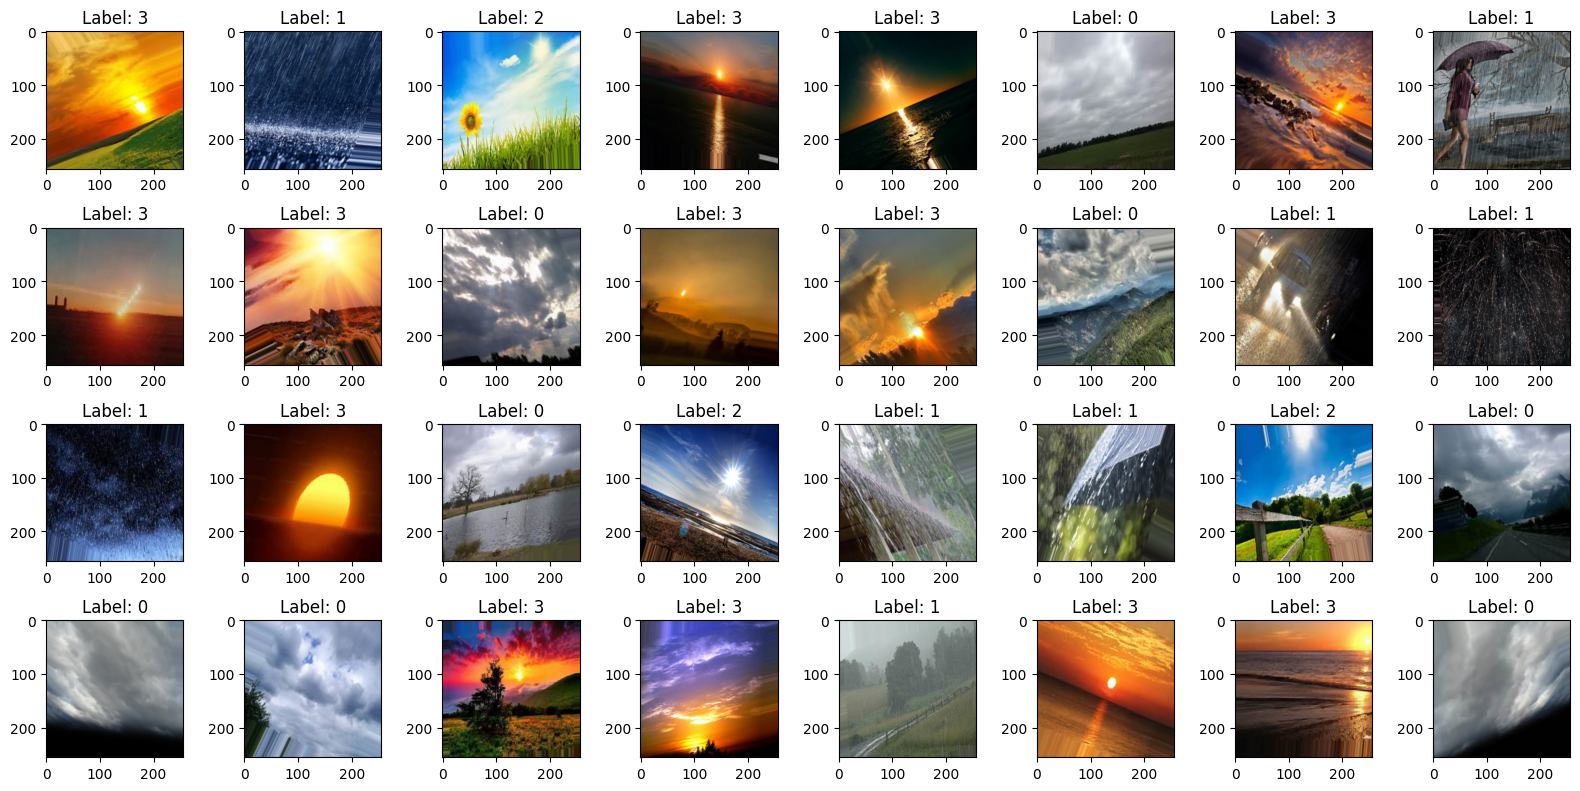

In [7]:
# Extract a batch of images and labels from the generator
images, labels = next(train_generator)

# Plot the images and their corresponding labels
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))s
    ax.set_title(f"Label: {labels[i].argmax()}")

plt.tight_layout()
plt.show()

## Building the Vision Transformer

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Set the random seed for reproducibility
tf.random.set_seed(42)

def create_vit_model(img_size, num_classes):
    # Patch size and number of patches
    patch_size = 16
    num_patches = (img_size // patch_size) ** 2
    # Embedding dimension
    embed_dim = 256
    # Number of transformer blocks
    num_transformer_blocks = 4
    # Number of attention heads
    num_heads = 8
    # Feedforward network dimension
    ff_dim = 512
    
    # Input layer
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Patch embedding layer
    patch_embed = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)

    # Position embedding layer
    pos_embed = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(tf.range(start=0, limit=num_patches, delta=1))
    pos_embed = layers.Lambda(lambda x: tf.reshape(x, shape=(-1, num_patches, embed_dim)))(pos_embed)
    pos_embed = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(pos_embed)  # Add extra dimension to match attn_output

    # Add extra dimension to patch_embed
    patch_embed = layers.Reshape(target_shape=(1, num_patches, embed_dim))(patch_embed)

    # Add pos_embed and patch_embed
    pos_embed = layers.Add()([pos_embed, patch_embed])
    pos_embed = layers.Reshape(target_shape=(num_patches, embed_dim))(pos_embed)

    # Transformer blocks
    for i in range(num_transformer_blocks):
        # Multi-head self-attention layer
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(pos_embed, pos_embed)
        attn_output = layers.Dropout(0.1)(attn_output)
        attn_output = layers.LayerNormalization(epsilon=1e-6)(layers.Add()([pos_embed, attn_output]))
        # Feed-forward layer
        feed_forward = layers.Dense(ff_dim, activation="relu")(attn_output)
        feed_forward = layers.Dense(embed_dim)(feed_forward)
        feed_forward = layers.Dropout(0.1)(feed_forward)
        feed_forward = layers.LayerNormalization(epsilon=1e-6)(layers.Add()([attn_output, feed_forward]))
        # Set the output of this transformer block as the input to the next block
        pos_embed = feed_forward
        
    # Global average pooling layer
    global_avg_pool = layers.GlobalAveragePooling1D()(pos_embed)

    # Output layer
    outputs = layers.Dense(num_classes, activation="softmax")(global_avg_pool)

    
    # Create and compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create model
model = create_vit_model(img_size, num_classes)

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
22/22 [==============================] - 703s 31s/step - loss: 1.5508 - accuracy: 0.3639 - val_loss: 1.0167 - val_accuracy: 0.5580
Epoch 2/10
22/22 [==============================] - 24s 1s/step - loss: 0.8573 - accuracy: 0.6228 - val_loss: 0.9614 - val_accuracy: 0.6250
Epoch 3/10
22/22 [==============================] - 19s 876ms/step - loss: 0.7395 - accuracy: 0.6760 - val_loss: 0.9351 - val_accuracy: 0.6384
Epoch 4/10
22/22 [==============================] - 21s 987ms/step - loss: 0.6810 - accuracy: 0.7263 - val_loss: 0.9948 - val_accuracy: 0.6339
Epoch 5/10
22/22 [==============================] - 19s 865ms/step - loss: 0.5652 - accuracy: 0.7781 - val_loss: 0.7900 - val_accuracy: 0.7366
Epoch 6/10
22/22 [==============================] - 20s 918ms/step - loss: 0.5778 - accuracy: 0.7544 - val_loss: 0.9872 - val_accuracy: 0.6250
Epoch 7/10
22/22 [==============================] - 19s 864ms/step - loss: 0.4834 - accuracy: 0.8166 - val_loss: 0.7667 - val_accuracy: 0.7054
Epo

##Evaluate the model on the test set

8/8 [==============================] - 154s 22s/step - loss: 0.5706 - accuracy: 0.7511
Test loss: 0.5706254243850708
Test accuracy: 0.7511110901832581
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


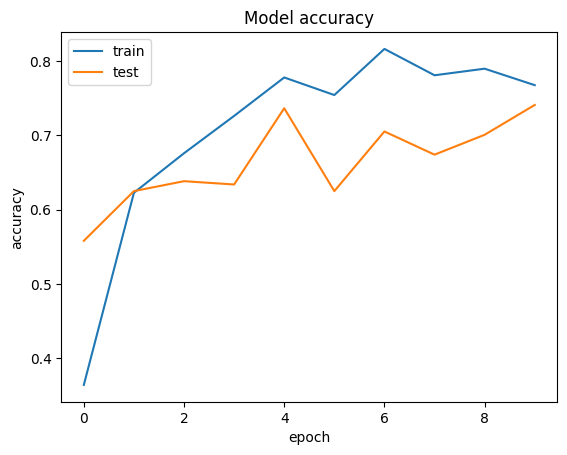

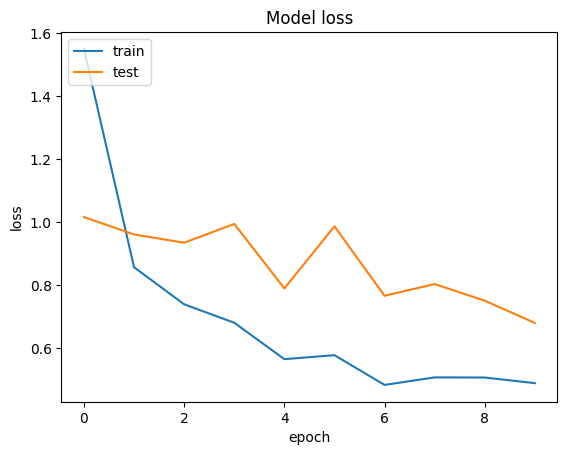

8/8 [==============================] - 3s 359ms/step
              precision    recall  f1-score   support

           0       0.64      0.68      0.66        60
           1       0.64      0.49      0.55        43
           2       0.73      0.84      0.78        51
           3       0.93      0.90      0.91        71

    accuracy                           0.75       225
   macro avg       0.73      0.73      0.73       225
weighted avg       0.75      0.75      0.75       225



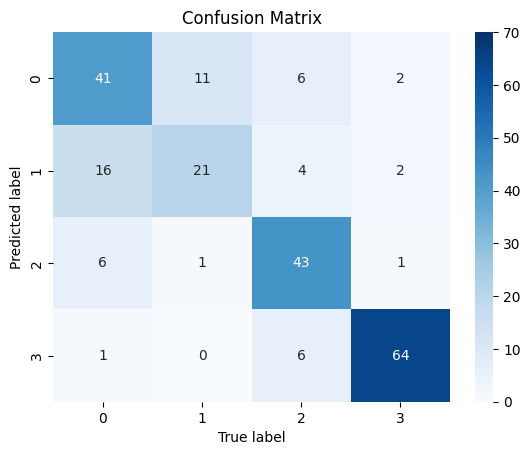

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evalPlots(model, history):
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_generator)
    
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)

    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Generate predictions on test set
    y_pred = np.argmax(model.predict(test_generator), axis=1)
    #y_true = np.concatenate([y for x, y in test_generator], axis=0)
    y_test = test_generator.classes

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', vmin = 0, vmax = 70)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

evalPlots(model, history)

In [ ]:
# print(train_data.class_indices)
# print(val_data.class_indices)
# print(test_data.class_indices)

## Define multi head attention layer

In [ ]:
# class MultiHeadAttention(layers.Layer):
#     def __init__(self, d_model, n_heads):
#         super(MultiHeadAttention, self).__init__()
#         self.d_model = d_model
#         self.n_heads = n_heads
#         self.depth = d_model // n_heads

#         self.query_dense = layers.Dense(units=d_model)
#         self.key_dense = layers.Dense(units=d_model)
#         self.value_dense = layers.Dense(units=d_model)

#         self.dense = layers.Dense(units=d_model)

#     def split_heads(self, inputs, batch_size):
#         inputs = tf.reshape(inputs, shape=(batch_size, -1, self.n_heads, self.depth))
#         return tf.transpose(inputs, perm=[0, 2, 1, 3])

#     def call(self, inputs):
#         query = inputs
#         key = inputs
#         value = inputs
#         batch_size = tf.shape(query)[0]

#         query = self.query_dense(query)
#         key = self.key_dense(key)
#         value = self.value_dense(value)

#         query = self.split_heads(query, batch_size)
#         key = self.split_heads(key, batch_size)
#         value = self.split_heads(value, batch_size)

#         scaled_attention_logits = tf.matmul(query, key, transpose_b=True)
#         scaled_attention_logits /= tf.math.sqrt(tf.cast(self.depth, tf.float32))
#         attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
#         scaled_attention = tf.matmul(attention_weights, value)
#         scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
#         concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
#         outputs = self.dense(concat_attention)
#         return outputs

##Define positional encoding

In [ ]:
# class PositionalEncoding(Layer):
#     def __init__(self, max_len, embedding_dim, **kwargs):
#         super(PositionalEncoding, self).__init__(**kwargs)
#         self.max_len = max_len
#         self.embedding_dim = embedding_dim

#     def build(self, input_shape):
#         self.pos_enc = self.add_weight(name='pos_enc',
#                                        shape=(self.max_len, self.embedding_dim),
#                                        initializer=self._positional_encoding_initializer(),
#                                        trainable=False)
#         super(PositionalEncoding, self).build(input_shape)

#     def call(self, x):
#         seq_len = tf.shape(x)[1]
#         return x + self.pos_enc[:seq_len, :]

#     def _positional_encoding_initializer(self):
#         pos_enc = np.zeros((self.max_len, self.embedding_dim))
#         for pos in range(self.max_len):
#             for i in range(0, self.embedding_dim, 2):
#                 angle = pos / np.power(10000, (2 * i) / self.embedding_dim)
#                 pos_enc[pos, i] = np.sin(angle)
#                 pos_enc[pos, i+1] = np.cos(angle)
#         return tf.constant_initializer(pos_enc)


## Implementation of the FeedForwardNetwork class:

In [ ]:
# class FeedForwardNetwork(Layer):
#     def __init__(self, hidden_dim, ff_dim, **kwargs):
#         super(FeedForwardNetwork, self).__init__(**kwargs)
#         self.hidden_dim = hidden_dim
#         self.ff_dim = ff_dim

#     def build(self, input_shape):
#         self.fc1 = Dense(units=self.ff_dim, activation='relu')
#         self.fc2 = Dense(units=self.hidden_dim)
#         super(FeedForwardNetwork, self).build(input_shape)

#     def call(self, x):
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

## Define the Vision Transformer model

In [ ]:
# class VisionTransformer(tf.keras.models.Model):
#     def __init__(self, num_classes, patch_size, num_patches, d_model, num_heads, dff, dropout_rate):
#         super(VisionTransformer, self).__init__()

#         self.patch_size = patch_size
#         self.num_patches = num_patches
#         self.d_model = d_model
#         self.num_heads = num_heads
#         self.dff = dff
#         self.dropout_rate = dropout_rate

#         # Embedding layer
#         self.embedding_layer = tf.keras.layers.Conv2D(filters=d_model,
#                                                       kernel_size=patch_size,
#                                                       strides=patch_size,
#                                                       padding='valid',
#                                                       activation='relu')
        
#         # Positional embedding layer
#         self.positional_encoding_layer = PositionalEncoding(num_patches, d_model)
        
#         # Multi-head self-attention layers
#         self.attention_layers = [MultiHeadAttention(num_heads, d_model) for _ in range(8)]
        
#         # Feedforward network layers
#         self.feedforward_layers = [FeedForwardNetwork(d_model, dff) for _ in range(8)]
        
#         # Output layer
#         self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

#         # Dropout layer
#         self.dropout_layer = tf.keras.layers.Dropout(rate=dropout_rate)

#     def call(self, x):
#         # Embedding layer
#         x = self.embedding_layer(x)
        
#         # Rearrange patches
#         x = tf.transpose(x, perm=[0, 3, 1, 2])
#         x = tf.reshape(x, [-1, self.num_patches, self.d_model])
        
#         # Add positional encoding
#         x = self.positional_encoding_layer(x)
        
#         # Multi-head self-attention layers
#         for i in range(8):
#             x = self.attention_layers[i](x)
#             x = self.dropout_layer(x)
        
#         # Feedforward network layers
#         for i in range(8):
#             x = self.feedforward_layers[i](x)
#             x = self.dropout_layer(x)

#         # Output layer
#         x = self.output_layer(x)
#         return x

##Train the model on training data

In [ ]:
# learning_rate = 0.001
# num_epochs = 10

# # Define loss function and optimizer
# loss_fn = tf.keras.losses.CategoricalCrossentropy()
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# history = model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Define metrics
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

# # Train the model
# for epoch in range(num_epochs):
#     # Reset metrics at the start of each epoch
#     train_loss.reset_states()
#     train_accuracy.reset_states()
#     test_loss.reset_states()
#     test_accuracy.reset_states()

#     for images, labels in train_dataset:
#         # Forward pass
#         with tf.GradientTape() as tape:
#             predictions = model(images, training=True)
#             loss = loss_fn(labels, predictions)

#         # Compute gradients
#         gradients = tape.gradient(loss, model.trainable_variables)

#         # Update weights
#         optimizer.apply_gradients(zip(gradients, model.trainable_variables))

#         # Update metrics
#         train_loss.update_state(loss)
#         train_accuracy.update_state(labels, predictions)

#     for images, labels in test_dataset:
#         # Forward pass
#         predictions = model(images, training=False)
#         loss = loss_fn(labels, predictions)

#         # Update metrics
#         test_loss.update_state(loss)
#         test_accuracy.update_state(labels, predictions)

#     # Print progress
#     template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
#     print(template.format(epoch+1,
#                           train_loss.result(),
#                           train_accuracy.result()*100,
#                           test_loss.result(),
#                           test_accuracy.result()*100))